In [ ]:
import numpy as np
import cupy as cp
import pandas as pd
import scipy

from cupyx.profiler import benchmark; 
import time
import matplotlib.pyplot as plt

%matplotlib inline
!nvidia-smi

Sat Dec 10 18:52:26 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    27W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## CuPy:
- Open source library to allow GPU-accelerated Python programming. Not just a NumPy replacement, but can function like that if you want it to.
- CuPy is easy to use. Replaces NumPy in most general cases.
- Interacts with more and more libraries safely for GPU Optimizations. But not all, and not always with speedup. 
- CuPy was built for neural networks, but was given it's own library through popular demand on open source (GitHub).
- CuPy can be easy to use but also gives you the chance to make even more optimizations in various different ways.


## Google Colab
- Alternatives
 - Every day there are more and more alternatives to Google Colab. 
 - Consider:
    - https://hex.tech/ (SQL Integration, Google Docs like collaboration, new and cool)
    - Notebooks possible in VSC (Microsoft) 
    - Amazon Sagemaker (Jupyter equivalent)
- Google Colab gets a lot of hate, some of it is right. Some I found online included: 
  - Service interruptions
  - Slow storage
  - Non-configured environments
  - Feature-poor
  - It crashes (probably my fault, but also because a free service does not need to provide infinite computing resources to non-paying customers)

- Colab Pro:
  - Faster GPUs, more computing units?
  - More memory through higher memory machine access
- Colab Pro+:
  - Second tier: Priority over Colab Pro for faster GPUs and more compute units. 
  - Background execution of your code, which may be useful for Data Science projects that involve lots of scraping or training, for example. Only up to 24 hours.
  - Not worth it. 5x as expensive as Colab Pro on a service that many already consider unreliable. 
- My issues:
  - Not the latest of every library is always pre-installed. Causes incompatability issues that are annoying to fix and re-run every session.
  - When you lose access, you have to re-run the entire notebook to see your variables again. 

In [ ]:
# Simple way to upgrade any package using pip
!pip install xgboost --upgrade
import xgboost as xgb
xgb.__version__
# Look for 1.7.1 for CuPy compatibility

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 193.6 MB 69 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


'1.7.2'

### Working with CuPy arrays:

- CuPy is a GPU array backend. 
- Many parts of Numpy's interface works with CuPy too. 
- The cupy.ndarray class is in its core, which is a compatible GPU alternative of numpy.ndarray.
-  CuPy implements many functions on cupy.ndarray objects. 
- CuPy has a way for us to easily access NumPy versions of GPU-enabled arrays.

In [ ]:
#  Initialize a numpy array:
x_cpu = np.array([1,2,3,4,5,6])

#  Initialize a cupy array in either way:
x_gpu = cp.array([1,2,3,4,5,6])

print(type(x_gpu.get()))
##         OUT: <class 'numpy.ndarray'> ##

# What about different types?
# use .get()
# numpy has a dot function, so cupy does to
dot_product = cp.dot(x_cpu, x_gpu.get())

print(type(dot_product))
## OUT:    <class 'numpy.int64'>       ##


#  Fixing different types
#  cupy can take numpy arrays with .asarray()
better_dot_product = cp.dot(cp.asarray(x_cpu), x_gpu)


print(type(better_dot_product))
## OUT:    <class 'cupy.ndarray'>      ##


# Doing the norm
l2_cpu = np.linalg.norm(x_cpu)
l2_gpu = cp.linalg.norm(x_gpu)


# add using python
# interoperability
# hardest word I've ever said
py_add = l2_cpu + l2_gpu
print(type(py_add))

# or just add using cupy
cupy_added_vector = cp.add(l2_gpu, l2_cpu)
print(type(cupy_added_vector))

#   both
#   OUT: cupy.ndarray

# Is it equal?
print(cupy_added_vector == py_add)

del better_dot_product, dot_product, cupy_added_vector, l2_cpu, l2_gpu, py_add, x_cpu, x_gpu

<class 'numpy.ndarray'>
<class 'numpy.int64'>
<class 'cupy.ndarray'>
<class 'cupy.ndarray'>
<class 'cupy.ndarray'>
True


###**Profiling**:

CuPy has a built in benchmarking tool, but it does not compare against CPU implementations yet. (active issue on GitHub)

CuPy shows speedups that are significant depending on the type of work and the size of the array. For smaller data, NumPy can generally be faster.

#### SciPy:
- "SciPy provides algorithms for optimization, integration, interpolation, eigenvalue problems, algebraic equations, differential equations, statistics and many other classes of problems."
- CuPy's main features is being a replacement for NumPy with SciPy allowing for speedup, but only on some operations is speedup significant. 


In [ ]:
# using Benchmark, built into CuPy

def my_gpu_func(a):
    return cp.sqrt(cp.sum(a**2, axis=-1))

a = cp.random.random((5000, 10240))

print(benchmark(my_gpu_func, (a,), n_repeat=50)) 
del(a)

my_gpu_func         :    CPU:  199.754 us   +/-51.889 (min:  143.747 / max:  432.148) us     GPU-0:41308.811 us   +/-38.542 (min:41271.297 / max:41510.975) us


In [ ]:
# Using a Device synchronize
# Using Python Time
# Standard way others seem to be logging the time comparison of functions in Cupy and Numpy

### Numpy and CPU ONES
s1 = time.time()
x_cpu = np.ones((1000,1000,1000)) # 1 billion
e1 = time.time()
print("CPU Ones Operation:", f'{e1 - s1}{" s"}')  


### CuPy and GPU ONES
s2 = time.time()
x_gpu = cp.ones((1000,1000,1000))
cp.cuda.Stream.null.synchronize() # Still have to synchronize
e2 = time.time()
print("GPU Ones Operation", f'{e2 - s2}{" s"}')
print("Speedup: " ,(e1-s1)/(e2-s2))
del(x_cpu, x_gpu)
print("")

### Numpy and CPU SUM 
x_cpu = np.ones((1000,1000,100)) # 100 Million
s1 = time.time()
x_cpu = np.sum(x_cpu)
e1 = time.time()
print("CPU Sum Operation:", f'{e1 - s1}{" s"}')  
del(x_cpu)


### CuPy and GPU SUM
x_gpu = cp.ones((1000,1000,100))
s2 = time.time()
x_gpu = np.sum(x_gpu)
cp.cuda.Stream.null.synchronize() # Still have to synchronize
e2 = time.time()
print("GPU Sum Operation", f'{e2 - s2}{" s"}')
print("Speedup: " ,(e1-s1)/(e2-s2))
del(x_gpu)

print("")

### Numpy and CPU Polyvander 
s1 = time.time()
x_cpu = np.polynomial.polynomial.polyvander(np.random.rand(5000000), 1)
e1 = time.time()
print("CPU Polyvander Operation:", f'{e1 - s1}{" s"}')  
del(x_cpu)


### CuPy and GPU Polyvander
s2 = time.time()
x_gpu = cp.polynomial.polynomial.polyvander(cp.random.rand(5000000), 1)
cp.cuda.Stream.null.synchronize() # Still have to synchronize
e2 = time.time()
print("GPU Polyvander Operation", f'{e2 - s2}{" s"}')
print("Speedup: " ,(e1-s1)/(e2-s2))
del(x_gpu)

del(e1,s2,e2,s1)

CPU Ones Operation: 0.799933671951294 s
GPU Ones Operation 0.0089874267578125 s
Speedup:  89.0058626910017

CPU Sum Operation: 0.06601834297180176 s
GPU Sum Operation 0.000888824462890625 s
Speedup:  74.27601931330472

CPU Polyvander Operation: 0.07551908493041992 s
GPU Polyvander Operation 0.0008699893951416016 s
Speedup:  86.8046040010962


## More speedup is possible. 
- Launch with environment variable: CUPY_ACCELERATORS=cub python for even faster speedups using the CUB

### What is CUB? (CUDA UnBound)
- Provides state-of-the-art, reusable software components for every layer of the CUDA programming model: 
- Seems to implement some of the things we manually wrote in class, essentially.
- " Collectives allow complex parallel code to be re-used rather than re-implemented, and to be re-compiled rather than hand-ported. "

> https://nvlabs.github.io/cub/




---



**Block Reduce Example Code:**

https://nvlabs.github.io/cub/classcub_1_1_block_reduce.html

> ![art_1.PNG](https://nvlabs.github.io/cub/reduce_logo.png)


```
__global__ void add(float* blocksum)
{
   float G = 1.0;
  // Block wise reduction so that one thread in each block holds sum of thread  results
    typedef cub::BlockReduce<float, BLOCK_SIZE, cub::BLOCK_REDUCE_RAKING, BLOCK_SIZE> BlockReduce;

    __shared__ typename BlockReduce::TempStorage temp_storage;
    float aggregate = BlockReduce(temp_storage).Sum(G);
    __syncthreads();
    if (threadIdx.x == 0 && threadIdx.y == 0)
        blocksum[blockIdx.y*gridDim.x + blockIdx.x] = aggregate;
}

```



####Speedup measurements on single GPU for some operations:

![speedups](https://miro.medium.com/max/720/1*-v7rQQd4QTAM8QV-yMhJSw.webp)

###**CuPy, Numba, and their value**

- CuPy is different to Numba as it allows lower-level changes to your programs. 

- It uses CUDA-related libraries including cuBLAS, cuDNN, cuRand, cuSolver, cuSPARSE, cuFFT and NCCL to make full use of the GPU architecture. 

- NumPy is ubiquitous in Python, but does not take advantage of NVIDIA GPUs. 

- CuPy as a drop-in replacement with these added features can be a powerful and quick way to achieve significant speedup.




##**Regression model of arrays in CuPy:**

- Model created in CuPy
- Model created in (serial = realistic NumPy implementation) Python

1


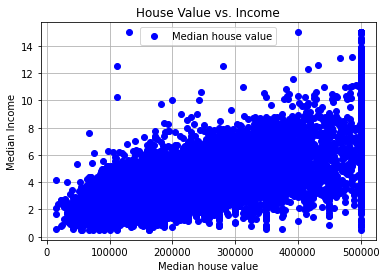

CPU Linear Fitting Operation 0.002393484115600586 s


In [ ]:
## 
print(cp.cuda.runtime.getDeviceCount())
data = pd.read_csv("/content/sample_data/california_housing_train.csv")
data.dropna()
A = data[['median_house_value','median_income']]
np_matrix = np.array(A.values,'float')

plt.plot(np_matrix[:,0],np_matrix[:,1],'bo')
plt.ylabel('Median Income')
plt.xlabel('Median house value')
plt.legend(['Median house value'])
plt.title('House Value vs. Income')
plt.grid()
plt.show()

s = time.time()

fit = np.polyfit(np_matrix[:,0],np_matrix[:,1], 1)

e = time.time()
print("CPU Linear Fitting Operation", f'{e - s}{" s"}')
del(data, np_matrix, A, e, s)

In [ ]:
data = pd.read_csv("/content/sample_data/california_housing_train.csv")
data.dropna()
A = data[['median_house_value','median_income']]
cp_matrix = cp.array(A.values,'float')

s = time.time()

cp.polyfit(cp_matrix[:,0],cp_matrix[:,1], 1)

e = time.time()
print("GPU Linear Fitting Operation", f'{e - s}{" s"}')
del(data, cp_matrix, A, e, s)

GPU Linear Fitting Operation 0.003510713577270508 s


###Decorators
CuPy comes with decorators to do some custom kernels.

https://docs.cupy.dev/en/stable/reference/kernel.html



In [25]:
## GPU VERSION ##

size = 10000    # array size

a = cp.float32(2.0)
x = cp.ones((1024,size),'f')
y = cp.ones((1024,size),'f')

@cp.fuse()
def saxpy(a, x, y):
  return a * x + y


s1 = time.time()
saxpy(a,x,y)
e1 = time.time()

print("GPU Fuse Kernel", f'{e1 - s1}{" s"}')
del(x,y,a)

GPU Fuse Kernel 0.0007264614105224609 s


In [26]:
## CPU VERSION ##

a = np.float32(2.0)
x = np.ones((1024,size),'f')
y = np.ones((1024,size),'f')

def saxpy(a, x, y):
  return a * x + y

s2 = time.time()
saxpy(a,x,y)
e2 = time.time()

print("CPU Fuse Kernel", f'{e2 - s2}{" s"}')
print("Total speedup:", ((e2-s2)/(e1-s1)))
del(x,y,a,size)

CPU Fuse Kernel 0.01478433609008789 s
Total speedup: 20.351165080406957


#### Speed differences are noticeable on higher N arrays.
There are many more decorators provided by CuPy. 

![saxpy](https://i.imgur.com/ayMrnVs.png)

## Making **XGBoost** faster so we can tune faster

XGBoost is an algorithm that uses gradient boosted trees. The graphic below explains what this is and how it is related to Decision Trees.

A general problem with gradient boosted decision trees is that they are quick to learn and overfit training data.

One effective way to improve models in the gradient boosting algorithm is to use a slower learning rate (at some cost to us). We may be able to improve the overall chances of us succesfully extrapolating our model.

Tuning boosted trees is important. Below is an already tuned model but it may be possible to extract even better performance through a hyperparameter grid and brute forcing the algorithm. 

![art_1.PNG](https://miro.medium.com/max/1400/1*QJZ6W-Pck_W7RlIDwUIN9Q.jpeg)

![art_1.PNG](https://miro.medium.com/max/883/1*8sV6Sr9uc0Ef39YBivLzrw.jpeg)


In [ ]:
import pandas as pd
import numpy as np
import time
import cupy as cp
from cupyx.profiler import benchmark; import time
import xgboost as xgb
import seaborn
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
cp.cuda.get_device_id()

0

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,3.883578,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,1.908157,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,2.566375,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,3.544600,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,4.767000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


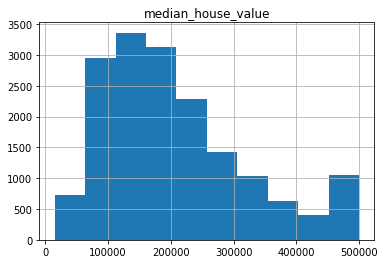

In [ ]:
data = pd.read_csv("/content/sample_data/california_housing_train.csv")
data.dropna()

# Estimate Median_house_value using all other predictors

data.hist("median_house_value")
data.describe()


In [ ]:
data = pd.read_csv("/content/sample_data/california_housing_train.csv")
data.dropna()
y = data.median_house_value
X = data.drop(['median_house_value'], axis=1)

s1 = time.time()
np_matrix = np.array(X)
np_y = np.array(y)

test = pd.read_csv("/content/sample_data/california_housing_test.csv")
test.dropna()
By = test.median_house_value
Bx = test.drop(['median_house_value'], axis=1)

test_matrix = np.array(Bx)
test_y = np.array(By)

print(type(np_matrix))

# "colsample_by_tree" is the fraction of features (randomly selected) that will be used to train each tree.
# max_depth = depth of the trees
# subsample = the fraction of the training samples (randomly selected) that will be used to train each tree.
# alpha = responsible for L1 regularization on leaf weight
# The regularization’s objective is to counter overfitting models by lowering variance while increasing some bias. (Variance Bias Tradeoff) 
# Lasso(L1) adds the sum of the absolute beta coefficients
# hist tree method: An approximation tree method. 

my_model = XGBRegressor(objective='reg:squarederror', colsample_bytree= 1, learning_rate = 0.01,
                         max_depth = 7, alpha = 10, n_estimators = 1000, subsample=0.6, booster = 'gbtree')

my_model.fit(np_matrix, np_y, verbose=False)


# make predictions
predictions = my_model.predict(test_matrix)
e1 = time.time()

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y)))
print("Time taken:", e1-s1, "s")

<class 'numpy.ndarray'>
Mean Absolute Error : 30978.976837239585
Time taken: 24.83057689666748 s


In [ ]:
data = pd.read_csv("/content/sample_data/california_housing_train.csv")


y = data.median_house_value
X = data.drop(['median_house_value'], axis=1)

s2 = time.time()
cp_matrix = cp.array(X.values)
cp_y = cp.array(y.values)

print(type(cp_matrix))

test = pd.read_csv("/content/sample_data/california_housing_test.csv")

By = test.median_house_value
Bx = test.drop(['median_house_value'], axis=1)
test_matrix = cp.array(Bx)
test_y = cp.array(By)

# https://xgboost.readthedocs.io/en/stable/gpu/index.html

my_model = XGBRegressor(objective='reg:squarederror', colsample_bytree= 1, learning_rate = 0.015,
                         max_depth = 9, alpha = 10, n_estimators = 1500, subsample=0.6, booster = 'gbtree', n_jobs=-1, tree_method='gpu_hist', gpu_id=0, predictor='gpu_predictor')

my_model.fit(cp_matrix, cp_y)


# make predictions
predictions = my_model.predict(test_matrix)
e2 = time.time()

print("Mean Absolute Error : " + str(mean_absolute_error(predictions, test_y.get())))
print("Time taken:", e2 - s2, "s")

<class 'cupy.ndarray'>
Mean Absolute Error : 29719.547342447917
Time taken: 8.91966438293457 s


In [ ]:
#Cleanup cell
del(Bx,By,X,cp_matrix,cp_y,data,np_matrix,np_y,predictions,test,test_matrix,test_y,y)

*Use cleanup cell if you notice RAM or Disk space is maxing.*

## Premium vs. Non-Premium GPUs vs CPU:
- Average runtime on CPU: 14-20s.
- Average runtime on GPU without CuPy: 7.7s.
- Average runtime on non-premium GPU with CuPy: 3.2s.
- Average runtime on premium GPU with CuPy using all available resources (n-jobs = -1): 2.3s.
- Appears to be halving.
- Is that worth the $10?

### Simple Convolutional Neural Network

Using the Chainer library (which gives us simple tools to build our neural network) we can have a CuPy enabled neural network learn efficiently on our GPU.

In [1]:
!pip install chainer
import chainer
import chainer.functions as F
import chainer.links as L
from chainer.datasets import cifar
from chainer import iterators
from chainer import optimizers
from chainer import training
from chainer.training import extensions


class MyModel(chainer.Chain):
    # 3 convolution layers (links)
    # 2 fully-connected layers
    def __init__(self, n_out):
        super(MyModel, self).__init__()
        with self.init_scope():
            self.conv1=L.Convolution2D(None, 32, 3, 3, 1)
            self.conv2=L.Convolution2D(32, 64, 3, 3, 1)
            self.conv3=L.Convolution2D(64, 128, 3, 3, 1)
            self.fc4=L.Linear(None, 1000)
            self.fc5=L.Linear(1000, n_out)
    # we can call the chain like a function
    # this is where we do forward propogation
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        h = F.relu(self.conv2(h))
        h = F.relu(self.conv3(h))
        h = F.relu(self.fc4(h))
        h = self.fc5(h)
        return h

#check this for GPU ID        
!nvidia-smi -L # can always see fancy output by removing -L

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.0 MB 10.5 MB/s 
  Created wheel for chainer: filename=chainer-7.8.1-py3-none-any.whl size=967740 sha256=06303717b0179174ac55723f17b0ee142c0b6adda8a242597cde39ed64c88d41
  Stored in directory: /root/.cache/pip/wheels/c5/01/d5/3ef194fa83dbf1d97bab826ca2bf235071f412861189a7b9df
Successfully built chainer
NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



In [ ]:
# Convolutional neural network

def train(model_object, batchsize=64, gpu_id=0, max_epoch=20):

    # Dataset
    # Cifar 10: https://www.cs.toronto.edu/~kriz/cifar.html
    train, test = cifar.get_cifar10()

    # Iterator
    # Serial: Dataset iterator that serially reads the examples.
    train_iterator = iterators.SerialIterator(train, batchsize)

    # repeat=False:  Stops iteration at the end of the first epoch   
    # shuffle=False: Examples are extracted in the order of indexes
    test_iterator = iterators.SerialIterator(test, batchsize, False, False)
    


    # Classifier Model: We hope to classify the Cifar10 data 
    # We need to compute loss and accuracy for our model based on a given input and label
    model = L.Classifier(model_object)
    if gpu_id >=0:
        model.to_gpu(gpu_id)

    # Optimizer
    # https://docs.chainer.org/en/stable/reference/optimizers.html
    # We could set alpha here to slow learning rate, but this is already pretty slow on our machine
    optimizer = optimizers.Adam()   # https://docs.chainer.org/en/stable/reference/generated/chainer.optimizers.Adam.html#chainer.optimizers.Adam
    # Extension to stochastic gradient descent 
    optimizer.setup(model) 

    # Updater
    # Implements a training iteration
    updater = training.StandardUpdater(train_iterator, optimizer, device=gpu_id)
    # updater = training.StandardUpdater(train_iterator, optimizer)

    # Trainer
    # Replaces writing a training loop in trainer
    # Connected to the Updater so that we can optimize parameters of the model as we run
    trainer = training.Trainer(updater, (max_epoch, 'epoch'), out='{}_cifar10_result'.format(model_object.__class__.__name__))

    # Evaluator
    # Update models by using our evaluation set
    class TestModeEvaluator(extensions.Evaluator):
        def evaluate(self):
            model = self.get_target('main')
            ret = super(TestModeEvaluator, self).evaluate()
            return ret

    trainer.extend(extensions.LogReport())
    trainer.extend(TestModeEvaluator(test_iterator, model, device=gpu_id))
    # trainer.extend(TestModeEvaluator(test_iterator, model))
    
    # Build report and report images
    trainer.extend(extensions.PrintReport(['epoch', 'main/loss', 'main/accuracy', 'validation/main/loss', 'validation/main/accuracy', 'elapsed_time']))
    trainer.extend(extensions.PlotReport(['main/loss', 'validation/main/loss'], x_key='epoch', file_name='loss.png'))
    trainer.extend(extensions.PlotReport(['main/accuracy', 'validation/main/accuracy'], x_key='epoch', file_name='accuracy.png'))
    
    # Run model
    trainer.run()
    del trainer

    return model


gpu_id = 0

model = train(MyModel(10), gpu_id=gpu_id)
# model = train(MyModel(10))

epoch       main/loss   main/accuracy  validation/main/loss  validation/main/accuracy  elapsed_time
1           1.55158     0.438439       1.31555               0.5209                    63.6005       
2           1.22885     0.558039       1.21125               0.559713                  130.913       
3           1.07309     0.614617       1.10339               0.597631                  195.979       
4           0.94571     0.663332       1.12138               0.600518                  260.796       
5           0.839762    0.700348       1.03974               0.630573                  324.891       
6           0.73532     0.740377       1.07504               0.635748                  389.324       
7           0.632911    0.773448       1.11602               0.638535                  453.469       
8           0.520719    0.815901       1.15841               0.644705                  533.662       


predicted_label: frog
answer: frog


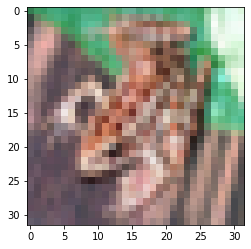

predicted_label: frog
answer: frog


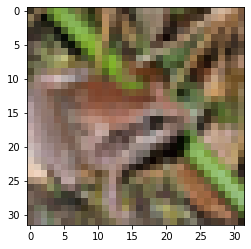

predicted_label: airplane
answer: airplane


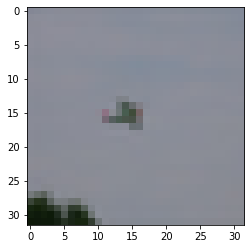

predicted_label: airplane
answer: airplane


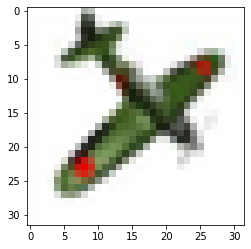

predicted_label: horse
answer: horse


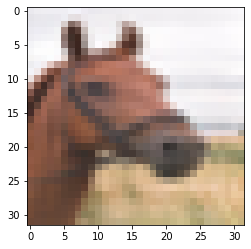

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# Cifar 10
# 10 class names, as listed below
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
             'dog', 'frog', 'horse', 'ship', 'truck']

# Predict by using the correct labels and our model predictions
# model.predictor()
def predict(model, image_id):
  
    # use _ to ignore variables
    _, test = cifar.get_cifar10()
    x, t = test[image_id]
    # need to return model to CPU 
    model.to_cpu()
    y = model.predictor(x[None, :]).data.argmax(axis=1)[0]
    print('predicted_label:', class_names[y])
    print('answer:', class_names[t])
    
    plt.imshow(x.transpose(1, 2, 0))
    plt.show()


for i in range(95,100):
    predict(model, i)

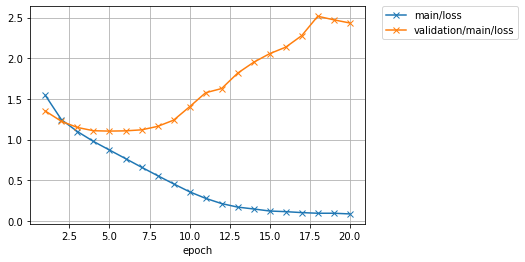

In [ ]:
from IPython.display import Image
Image(filename='MyModel_cifar10_result/loss.png')

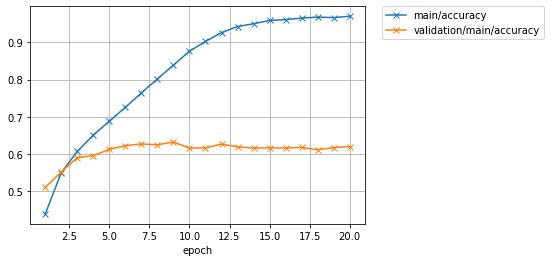

In [ ]:
Image(filename='MyModel_cifar10_result/accuracy.png')

### **Speedup and Analysis**

Per-epoch speed for the Premium GPU's was higher accross the board, with the first epoch being around 4x faster on average, and gradually this speedup diminished. We average around 7 seconds an epoch for both premium and non-premium GPUs. We basically gain only around 7 seconds of speed in our small task here.

I noticed a strange result in which the training and validation accuracy was higher on the Premium GPU. 

Final time speed on normal GPU average: ~155-166s+.

Premium GPU time:  ~148s

Just not seeing really a massive improvement despite the 'Premium GPU' tag on the system. Higher RAM not necessarily important for this task (especially small network).

CPU: Chainer is dependent on CuPy in this model, which means it cannot run on the CPU. From my research it appears that Chainer is considerably slower on a CPU, as expected.



Premium GPU: A100-SXM4-40GB

Standard GPU: Tesla T4